# YouTube Audience Network & User Communities analysis

## Overview

This notebook presents a comprehensive analysis of YouTube's audience network and user communities using the YouNiverse dataset. The analysis consists of two main parts:

### Part 1: Video-Video Audience Network
Constructs and analyzes an audience network where **videos are nodes** and **edges represent shared commenters**. This reveals how videos connect through their audiences and identifies hub videos that bridge different content communities.

### Part 2: User Community Detection
Analyzes user behavior patterns to identify distinct communities using two complementary approaches:
- **Feature-based clustering**: K-means on user activity, diversity, and engagement features
- **Graph-based clustering**: k-NN similarity graph with Louvain community detection

### Imports

In [8]:
#### Part for Google colab #####
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Add your project folder to the Python path
import sys
import os

# CHANGE THIS PATH to match your actual folder name in Drive
PROJECT_PATH = '/content/drive/My Drive/ADA_project/'
sys.path.append(PROJECT_PATH)

# 3. Install missing libraries (Colab has networkx/pandas, but might need python-louvain)
!pip install python-louvain

# 4. Check if it works
try:
    from utils import network_builder
    print("setup successful! Modules found.")
except ImportError:
    print("Error: Could not find your modules. Check the PROJECT_PATH.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
setup successful! Modules found.


In [9]:
import pandas as pd
import networkx as nx
import os
import ast
from utils.network_builder import build_video_projection_sparse
from data import data_loader
from itertools import combinations
from tqdm.notebook import tqdm
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import numpy as np

# Part 1: Safe pipeline
Implementation of initial idea of Video-Network
## 1.1 Load and filter




In [10]:
FILTERED_PATH = PROJECT_PATH + 'data/df_filtered_final.parquet'

if os.path.exists(FILTERED_PATH):
    print("Checkpoint 1: Loading pre-filtered data from disk...")
    df = pd.read_parquet(FILTERED_PATH)
else:
    print("Step 1: Loading and Filtering raw data (this takes time)...")

    # --- A. LOAD RAW DATA ---
    # Use your data_loader to load the compressed file
    # Adjust N_ROWS if you want the full dataset (set to None)
    df = data_loader.load_comments_gz(
        data_path=PROJECT_PATH + 'data/',
        comments_file='youtube_comments.tsv.gz',
        n_chunks=10,       # Adjust based on your RAM
        chunksize=500_000
    )

    # --- B. RENAME COLUMNS (Fixing common issues) ---
    if 'author' in df.columns:
        df.rename(columns={'author': 'author_id'}, inplace=True)

    print(f"   Loaded shape: {df.shape}")

    # --- C. FILTERING (Iterative K-Core) ---
    # Keep only users active in >5 videos and videos with >10 users
    MIN_VIDEOS_PER_USER = 5
    MIN_USERS_PER_VIDEO = 10

    print("   Filtering data (removing small users/videos)...")
    initial_len = len(df)

    # Simple iterative filter
    for i in range(3): # Run 3 passes to stabilize
        # Filter Users
        user_counts = df['author_id'].value_counts()
        valid_users = user_counts[user_counts >= MIN_VIDEOS_PER_USER].index
        df = df[df['author_id'].isin(valid_users)]

        # Filter Videos
        video_counts = df['video_id'].value_counts()
        valid_videos = video_counts[video_counts >= MIN_USERS_PER_VIDEO].index
        df = df[df['video_id'].isin(valid_videos)]

    print(f"   Filtered down to {len(df):,} rows (was {initial_len:,})")

    # --- D. SAVE CHECKPOINT ---
    df.to_parquet(FILTERED_PATH, index=False)
    print(f"Saved filtered data to {FILTERED_PATH}")

Checkpoint 1: Loading pre-filtered data from disk...


# 1.2 Enrich with metadata

In [11]:
# We need Channel & Category attached to the comments for your new analysis.
ENRICHED_PATH = PROJECT_PATH + 'data/df_enriched.parquet'

if os.path.exists(ENRICHED_PATH) and 'channel' in pd.read_parquet(ENRICHED_PATH).columns:
    print("Checkpoint 2: Loading enriched data (with channels)...")
    df = pd.read_parquet(ENRICHED_PATH)
else:
    # 1. Clean Video IDs in Main DF
    df['video_id'] = df['video_id'].astype(str).str.strip()
    unique_vids = df['video_id'].unique()

    # 2. Fetch Metadata
    print(f"   Fetching metadata for {len(unique_vids)} videos...")
    meta_map = data_loader.load_metadata_for_videos_gz(
        metadata_path=PROJECT_PATH + 'data/yt_metadata_en.jsonl.gz',
        video_ids=unique_vids,
        verbose=True
    )

    # 3. THE FIXED CATEGORY CLEANER
    def clean_cat(c):
        # Case 1: It's None or Empty
        if not c:
            return "Unknown"

        # Case 2: It's a list -> ['Music']
        if isinstance(c, list):
            return c[0] if len(c) > 0 else "Unknown"

        # Case 3: It's a string -> "Music" or "['Music']"
        if isinstance(c, str):
            c = c.strip()
            if c.startswith('['):
                try:
                    # Try parsing "['Music']"
                    parsed = ast.literal_eval(c)
                    return parsed[0] if parsed else "Unknown"
                except:
                    return "Unknown"
            # It is just "Music" (THIS WAS THE BUG!)
            return c

        return "Unknown"

    # 4. Merge Logic
    meta_data = []
    for vid, info in meta_map.items():
        meta_data.append({
            'video_id': str(vid).strip(),
            # We use the ID because the Name is missing in your file
            'channel': str(info.get('channel', 'Unknown')).strip(),
            'category': clean_cat(info.get('categories')),
            'title': info.get('title', 'Unknown')
        })

    df_meta = pd.DataFrame(meta_data)

    # Drop old columns to avoid duplicates
    for col in ['channel', 'category', 'title']:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)

    # Merge
    df = df.merge(df_meta, on='video_id', how='left')

    # Fill missing
    df.fillna({'channel': 'Unknown', 'category': 'Unknown'}, inplace=True)

    # Save
    df.to_parquet(ENRICHED_PATH, index=False)
    print(f"Fixed! Saved enriched data to {ENRICHED_PATH}")
    print("   Sample Category:", df['category'].iloc[0])

Checkpoint 2: Loading enriched data (with channels)...


### Debug part 1.2

In [12]:
print("Reloading saved states...")

# 2. Reload the DataFrame (Try Enriched first, then Filtered)
enriched_path = PROJECT_PATH + 'data/df_enriched.parquet'
filtered_path = PROJECT_PATH + 'data/df_filtered_final.parquet'

if os.path.exists(enriched_path):
    print(f"Loading Enriched Data from: {enriched_path}")
    df = pd.read_parquet(enriched_path)
elif os.path.exists(filtered_path):
    print(f"Enriched data not found. Loading Filtered data: {filtered_path}")
    df = pd.read_parquet(filtered_path)
else:
    print("No saved dataframe found. You might need to run Part 1 (Load & Filter) first.")

# 3. Reload the Channel Graph (if it exists)
channel_graph_path = PROJECT_PATH + "data/channel_category_network.gexf"

if os.path.exists(channel_graph_path):
    print(f"Loading Channel Graph from: {channel_graph_path}")
    G_channels = nx.read_gexf(channel_graph_path)
else:
    print("Channel Graph not found on disk.")

# --- NOW RUN YOUR DEBUGGING CODE ---
print("\n DEBUG OUTPUT:")
if 'df' in locals():
    print("1. Sample Video IDs in your DataFrame:")
    print(df['video_id'].head().tolist())
    print(f"   Type: {df['video_id'].dtype}")

    print("\n2. What does the 'Enriched' DataFrame look like?")
    # Check if columns exist before printing to avoid errors
    cols_to_check = [c for c in ['video_id', 'channel', 'category'] if c in df.columns]
    print(df[cols_to_check].head(10))

if 'G_channels' in locals():
    print("\n3. What are the Graph Nodes named?")
    print(list(G_channels.nodes())[:10])

Reloading saved states...
Loading Enriched Data from: /content/drive/My Drive/ADA_project/data/df_enriched.parquet
Loading Channel Graph from: /content/drive/My Drive/ADA_project/data/channel_category_network.gexf

 DEBUG OUTPUT:
1. Sample Video IDs in your DataFrame:
['J7IMwop3RHs', 'v-hZgUtS7dk', '4gadOebTGWM', 'aP0bKcsSNuA', 'q-aZFxwX5Zs']
   Type: object

2. What does the 'Enriched' DataFrame look like?
      video_id                   channel        category
0  J7IMwop3RHs  UCjDLIm-vRiuKClRKlPd6JzQ           Music
1  v-hZgUtS7dk  UCh7EqOZt7EvO2osuKbIlpGg          Gaming
2  4gadOebTGWM  UCpGdL9Sn3Q5YWUH2DVUW1Ug          Gaming
3  aP0bKcsSNuA  UC5jkXpfnBhlDjqh0ir5FsIQ          Comedy
4  q-aZFxwX5Zs  UCcgVECVN4OKV6DH1jLkqmcA  People & Blogs
5  MH7aoE85Gdw  UCcgVECVN4OKV6DH1jLkqmcA  People & Blogs
6  zAGKnaSPnmI  UCgYfXYRxIPN2TuIyRkbH9fg   Entertainment
7  XHarZFMCdNo  UCDo9msNItILnyF_Y2eHaNQg           Music
8  3WVBsmP1JAc  UCsT-BupEK6M2LpAdBDojJsg          Gaming
9  zsmcj27xU00  UCe

# 1.3 Build video graph

In [13]:
GRAPH_PATH = PROJECT_PATH + 'data/video_network.gexf'

print("Step 3: Building Video Graph...")
G = build_video_projection_sparse(df)
nx.write_gexf(G, GRAPH_PATH)
print(f"Saved graph to {GRAPH_PATH}")
'''
if os.path.exists(GRAPH_PATH):
    print("Checkpoint 3: Loading existing graph...")
    G = nx.read_gexf(GRAPH_PATH)
else:
    print("Step 3: Building Video Graph...")
    G = build_video_projection_sparse(df)
    nx.write_gexf(G, GRAPH_PATH)
    print(f"Saved graph to {GRAPH_PATH}")
'''

Step 3: Building Video Graph...
--- Building Network from 964863 comments ---
Nodes (Videos): 45112
Connectors (Users): 31612
Calculating intersections (Sparse Dot Product)...
Filtering edges and calculating Jaccard...
Graph Built: 43132 videos, 1581204 edges
Saved graph to /content/drive/My Drive/ADA_project/data/video_network.gexf


'\nif os.path.exists(GRAPH_PATH):\n    print("Checkpoint 3: Loading existing graph...")\n    G = nx.read_gexf(GRAPH_PATH)\nelse:\n    print("Step 3: Building Video Graph...")\n    G = build_video_projection_sparse(df)\n    nx.write_gexf(G, GRAPH_PATH)\n    print(f"Saved graph to {GRAPH_PATH}")\n'

# 1.4 Calculate metrics

In [14]:
METRICS_PATH = PROJECT_PATH + 'data/video_metrics.csv'

if os.path.exists(METRICS_PATH):
    print("Checkpoint 4: Loading metrics...")
    df_metrics = pd.read_csv(METRICS_PATH)
    # Rebuild partition dict for later cells
    partition = dict(zip(df_metrics['video_id'], df_metrics['community']))
else:
    print("Step 4: Calculating Metrics...")
    # --- Community Detection ---
    import community.community_louvain as community_louvain
    partition = community_louvain.best_partition(G)

    # --- Centrality ---
    # (Use GPU code if you have it, otherwise CPU approx)
    clustering = nx.clustering(G, weight='weight')
    betweenness = nx.betweenness_centrality(G, k=100, weight='weight', seed=42) # Approx for speed

    # Save
    data = []
    for n in G.nodes():
        data.append({
            'video_id': n,
            'community': partition.get(n),
            'clustering': clustering.get(n, 0),
            'betweenness': betweenness.get(n, 0)
        })
    df_metrics = pd.DataFrame(data)
    df_metrics.to_csv(METRICS_PATH, index=False)
    print(f"Saved metrics to {METRICS_PATH}")

print("\n PIPELINE COMPLETE! You are ready for the new analysis.")

Checkpoint 4: Loading metrics...

 PIPELINE COMPLETE! You are ready for the new analysis.


# Part 2: Channel-Category Network (new idea)
That's a very clear and sophisticated insight! You've identified a common problem in network analysis called “supernode bias.”
Implementation of a new method to circumvent “supernode bias,” a common problem in network analysis.
To explain what this problem is, let's take an example: If “PewDiePie” has 1 million active fans who only comment on his videos, your current video graph looks like a giant ball of interconnected PewDiePie videos, which drowns out interesting connections to other channels.

To solve this problem, we move from a network of videos to a network of channels by grouping users of the same channel:

- **The strategy: channel-to-channel projection**

  - Instead of connecting video A to video B, we will connect channel X to channel Y.

  - Node: a channel (e.g., “MrBeast”).

  - Edge: the number of unique users who have commented on both channel X and channel Y.

  - Normalization: we must divide by the size of the channel to prevent large channels from dominating simply because they are large.

Now that you have completed step 1.2 (Enrichment) above, your df contains the essential columns relating to channels and categories. We can now implement your idea: “Compare channels based on common users, distinguishing between categories.”

In [15]:
def build_channel_category_network(df, min_shared_users=50):
    print("Building Channel-Category Network (Model B)...")

    # 1. Create Node IDs (Channel ID | Category)
    df['node_id'] = df['channel'].astype(str) + " | " + df['category'].astype(str)

    # 2. Group Users
    node_audiences = df.groupby('node_id')['author_id'].apply(set).to_dict()

    # 3. Build Edges
    edges = []
    valid_nodes = {k: v for k, v in node_audiences.items() if len(v) > min_shared_users}
    node_list = list(valid_nodes.keys())

    print(f"   Computing overlaps for {len(node_list)} active channel-categories...")

    for u, v in tqdm(combinations(node_list, 2), total=len(node_list)*(len(node_list)-1)//2):
        users_u = valid_nodes[u]
        users_v = valid_nodes[v]

        shared = len(users_u.intersection(users_v))

        if shared >= min_shared_users:
            union = len(users_u.union(users_v))
            weight = shared / union
            edges.append((u, v, weight, shared))

    # 4. Create Graph
    G_cc = nx.Graph()
    for n, users in valid_nodes.items():
        parts = n.split(" | ")
        chan = parts[0]
        cat = parts[1] if len(parts) > 1 else "Unknown"

        G_cc.add_node(n, label=chan, category=cat, size=len(users))

    for u, v, w, s in edges:
        G_cc.add_edge(u, v, weight=w, shared_users=s)

    print(f"Graph Built: {G_cc.number_of_nodes()} nodes.")
    return G_cc

# Execute
G_channels = build_channel_category_network(df, min_shared_users=50)

# Save it to look at in Gephi!
nx.write_gexf(G_channels, PROJECT_PATH + "data/channel_category_network.gexf")
print("  Saved Channel Network! Download 'channel_category_network.gexf' and open in Gephi.")

Building Channel-Category Network (Model B)...
   Computing overlaps for 1164 active channel-categories...


  0%|          | 0/676866 [00:00<?, ?it/s]

Graph Built: 1164 nodes.
  Saved Channel Network! Download 'channel_category_network.gexf' and open in Gephi.


# Part 3: Comparison of the two methods

graphs loading:

In [16]:
import networkx as nx
import os
import sys

# 1. Setup Path (Adjust if your path is different!)
PROJECT_PATH = '/content/drive/My Drive/ADA_project/'

print("🔄 Loading Graphs from disk...")

# ------------------------------------------
# LOAD MODEL A: Video Network (G)
# ------------------------------------------
video_graph_path = PROJECT_PATH + "data/video_network.gexf"

if os.path.exists(video_graph_path):
    print(f"   ⏳ Loading Video Graph (G) from: {video_graph_path}...")
    G = nx.read_gexf(video_graph_path)
    print(f"   ✅ Loaded G: {G.number_of_nodes()} videos, {G.number_of_edges()} edges.")
else:
    print(f"   ❌ File not found: {video_graph_path}")
    print("      -> You need to run 'Part 1: Build & Save Graph' first.")

# ------------------------------------------
# LOAD MODEL B: Channel Network (G_channels)
# ------------------------------------------
channel_graph_path = PROJECT_PATH + "data/channel_category_network.gexf"

if os.path.exists(channel_graph_path):
    print(f"   ⏳ Loading Channel Graph (G_channels) from: {channel_graph_path}...")
    G_channels = nx.read_gexf(channel_graph_path)
    print(f"   ✅ Loaded G_channels: {G_channels.number_of_nodes()} channels, {G_channels.number_of_edges()} edges.")
else:
    print(f"   ❌ File not found: {channel_graph_path}")
    print("      -> You need to run the 'New Idea' (Channel-Category Network) code first.")

print("\n🚀 Ready for Analysis!")

🔄 Loading Graphs from disk...
   ⏳ Loading Video Graph (G) from: /content/drive/My Drive/ADA_project/data/video_network.gexf...
   ✅ Loaded G: 43132 videos, 1581204 edges.
   ⏳ Loading Channel Graph (G_channels) from: /content/drive/My Drive/ADA_project/data/channel_category_network.gexf...
   ✅ Loaded G_channels: 1164 channels, 4362 edges.

🚀 Ready for Analysis!


In [17]:
def compare_structure(G_video, G_channel):
    # 1. Modularity (Community Strength)
    part_v = community_louvain.best_partition(G_video)
    mod_v = community_louvain.modularity(part_v, G_video)

    part_c = community_louvain.best_partition(G_channel)
    mod_c = community_louvain.modularity(part_c, G_channel)

    # 2. Density
    den_v = nx.density(G_video)
    den_c = nx.density(G_channel)

    print(f"Modularity (Clarity of Clusters): Video={mod_v:.3f} vs Channel={mod_c:.3f}")
    print(f"Density (Connectedness):        Video={den_v:.5f} vs Channel={den_c:.5f}")

compare_structure(G, G_channels)

Modularity (Clarity of Clusters): Video=0.750 vs Channel=0.440
Density (Connectedness):        Video=0.00170 vs Channel=0.00644


In [18]:
import community.community_louvain as community_louvain
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def run_comparative_analysis(G_video, G_channel):
    print("==============================================")
    print("  MODEL A (Video) vs. MODEL B (Channel)  ")
    print("==============================================\n")

    # --- 1. STRUCTURAL COMPARISON ---
    print("  STRUCTURAL HEALTH CHECK")

    den_v = nx.density(G_video)
    den_c = nx.density(G_channel)

    # Use weight='weight' for better stability
    part_v = community_louvain.best_partition(G_video, weight='weight')
    mod_v = community_louvain.modularity(part_v, G_video)

    part_c = community_louvain.best_partition(G_channel, weight='weight')
    mod_c = community_louvain.modularity(part_c, G_channel)

    print(f"{'Metric':<20} | {'Video Network (A)':<20} | {'Channel Network (B)':<20}")
    print("-" * 70)
    print(f"{'Nodes':<20} | {G_video.number_of_nodes():<20,} | {G_channel.number_of_nodes():<20,}")
    print(f"{'Edges':<20} | {G_video.number_of_edges():<20,} | {G_channel.number_of_edges():<20,}")
    print(f"{'Density':<20} | {den_v:.6f}             | {den_c:.6f}")
    print(f"{'Modularity':<20} | {mod_v:.3f}             | {mod_c:.3f}")
    print("-" * 70)

    # --- 2. SEMANTIC PURITY TEST ---
    print("\n SEMANTIC PURITY TEST")

    def get_purity(G, partition):
        # Find largest community
        df_p = pd.DataFrame.from_dict(partition, orient='index', columns=['comm_id'])
        largest_comm_id = df_p['comm_id'].value_counts().idxmax()
        nodes_in_largest = df_p[df_p['comm_id'] == largest_comm_id].index

        # Check 'category' attribute
        categories = []
        for n in nodes_in_largest:
            cat = G.nodes[n].get('category', 'Unknown')
            categories.append(str(cat))

        if not categories: return 0, "N/A"

        # Most common category
        top_cat, count = Counter(categories).most_common(1)[0]
        return (count / len(categories)) * 100, top_cat

    purity_c, cat_c = get_purity(G_channel, part_c)

    print(f"   -> In Model B (Channel), the largest community is dominated by '{cat_c}'.")
    print(f"   -> Purity Score: {purity_c:.1f}% of channels there are '{cat_c}'.")

    # --- 3. UPDATED RECOMMENDER SIMULATION ---
    print("\n  RECOMMENDER SIMULATION (Live Demo)")

    # A. AUTOMATIC MODE: Pick the biggest node (The Hub)
    # Since we don't know if 'MrBeast' is in your data, we pick the most connected node.
    sorted_nodes = sorted(G_channel.degree, key=lambda x: x[1], reverse=True)

    if sorted_nodes:
        hub_node = sorted_nodes[0][0] # The ID of the biggest channel

        # Try to make it readable (ID | Category)
        print(f"   Input Channel: '{hub_node}'")

        # Get top 3 neighbors by weight
        neighbors = sorted(G_channel[hub_node].items(), key=lambda x: x[1]['weight'], reverse=True)[:3]

        print(f"   Recommendations (based on shared audience):")
        for neighbor, attr in neighbors:
            print(f"      - {neighbor} (Strength: {attr['weight']:.2f})")
    else:
        print("   (Graph is empty, cannot run simulation.)")

# --- RUN IT ---
if 'G' in locals() and 'G_channels' in locals():
    run_comparative_analysis(G, G_channels)
else:
    print("Error: Load G and G_channels first.")

  MODEL A (Video) vs. MODEL B (Channel)  

  STRUCTURAL HEALTH CHECK
Metric               | Video Network (A)    | Channel Network (B) 
----------------------------------------------------------------------
Nodes                | 43,132               | 1,164               
Edges                | 1,581,204            | 4,362               
Density              | 0.001700             | 0.006444
Modularity           | 0.750             | 0.437
----------------------------------------------------------------------

 SEMANTIC PURITY TEST
   -> In Model B (Channel), the largest community is dominated by 'Entertainment'.
   -> Purity Score: 25.5% of channels there are 'Entertainment'.

  RECOMMENDER SIMULATION (Live Demo)
   Input Channel: 'UC-lHJZR3Gqxm24_Vd_AJ5Yw | Gaming'
   Recommendations (based on shared audience):
      - UC-lHJZR3Gqxm24_Vd_AJ5Yw | Entertainment (Strength: 0.31)
      - UC-lHJZR3Gqxm24_Vd_AJ5Yw | Comedy (Strength: 0.23)
      - UC-lHJZR3Gqxm24_Vd_AJ5Yw | People & Blogs

Visualization

Drawing Model A: Video Network (The 'Hairball')...


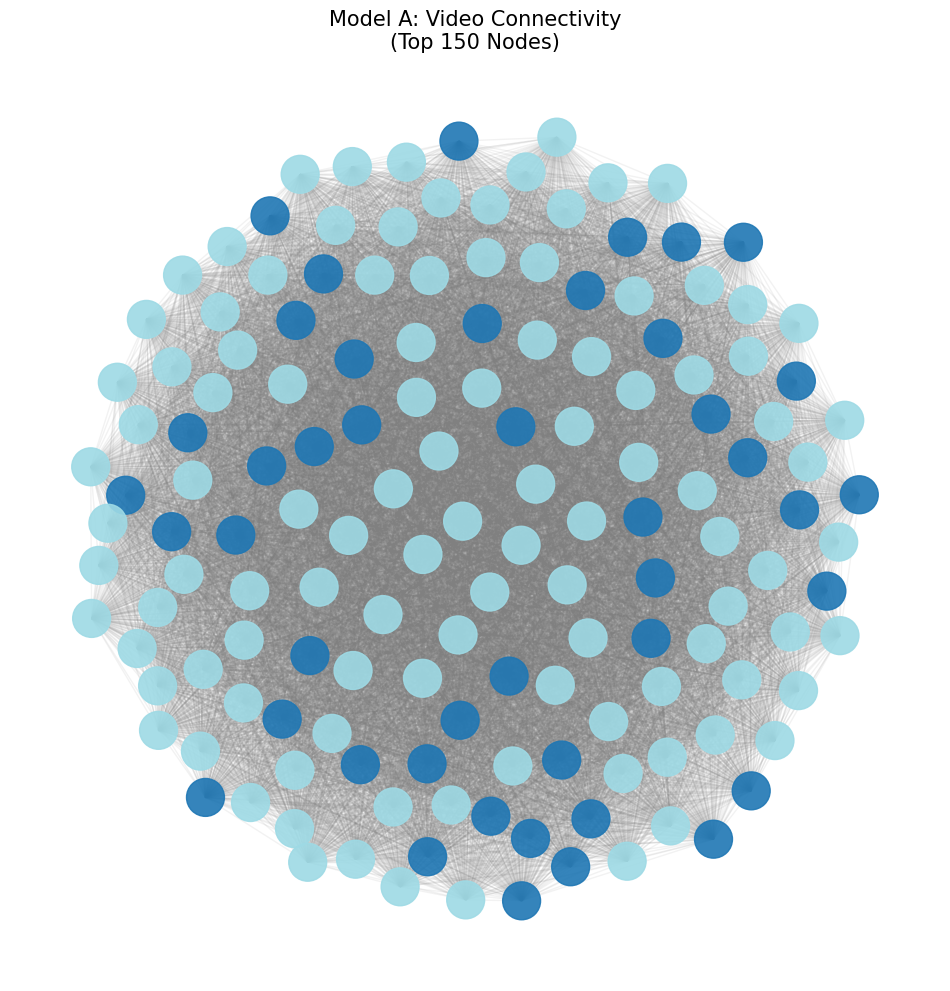

Drawing Model B: Channel-Category Network (The 'Map')...


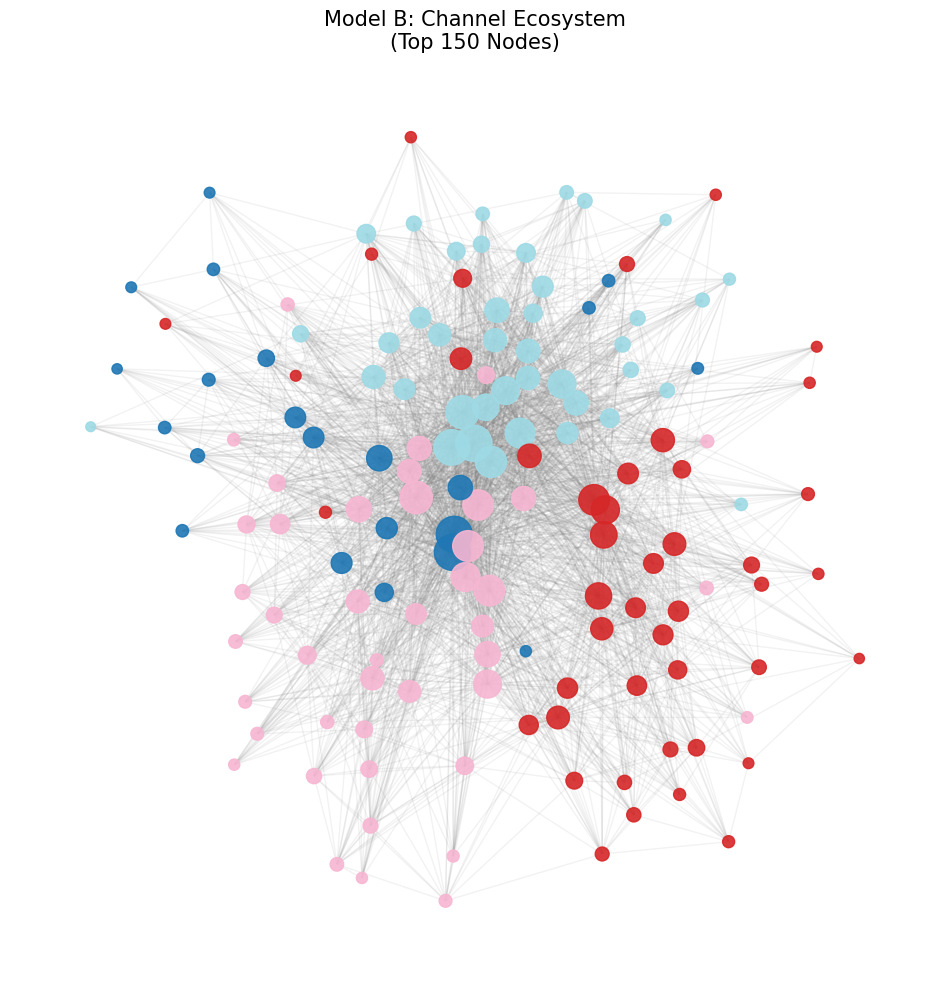

In [19]:
def visualize_network_skeleton(G, title, top_n=200, show_labels=False):
    plt.figure(figsize=(12, 12))

    # 1. FILTER: Keep only the most connected nodes (The "Skeleton")
    # Sort nodes by degree
    sorted_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)
    top_nodes = [n for n, d in sorted_nodes[:top_n]]

    # Create the subgraph
    H = G.subgraph(top_nodes)

    # 2. DETECT COMMUNITIES (for coloring)
    # Recalculate partition just for this subgraph view
    partition = community_louvain.best_partition(H)

    # 3. LAYOUT (Force-directed)
    # k controls the spacing between nodes (higher = more spread out)
    pos = nx.spring_layout(H, k=0.15, seed=42)

    # 4. DRAW
    # Nodes
    nx.draw_networkx_nodes(H, pos,
                           node_size=[v * 5 for v in dict(H.degree).values()], # Size by degree
                           cmap=plt.cm.tab20,
                           node_color=list(partition.values()),
                           alpha=0.9)

    # Edges (Make them faint)
    nx.draw_networkx_edges(H, pos, alpha=0.1, edge_color='gray')

    # Labels (Only if requested)
    if show_labels:
        # Only label the very top 20 to avoid clutter
        top_20 = top_nodes[:20]
        labels = {n: n.split(" | ")[0] for n in top_20} # Clean labels for Channels
        nx.draw_networkx_labels(H, pos, labels, font_size=10, font_weight='bold')

    plt.title(f"{title}\n(Top {top_n} Nodes)", fontsize=15)
    plt.axis('off')
    plt.show()

# --- RUN THE VISUALIZATION ---

print("Drawing Model A: Video Network (The 'Hairball')...")
# Video graph is usually messy, no labels needed
visualize_network_skeleton(G, "Model A: Video Connectivity", top_n=150, show_labels=False)

print("Drawing Model B: Channel-Category Network (The 'Map')...")
# Channel graph is cleaner, we WANT to see the names!
if 'G_channels' in locals():
    visualize_network_skeleton(G_channels, "Model B: Channel Ecosystem", top_n=150, show_labels=False)
else:
    print("G_channels not found. Run the 'New Idea' code block first.")

Generating L-Curve (Degree Distribution) Comparison...


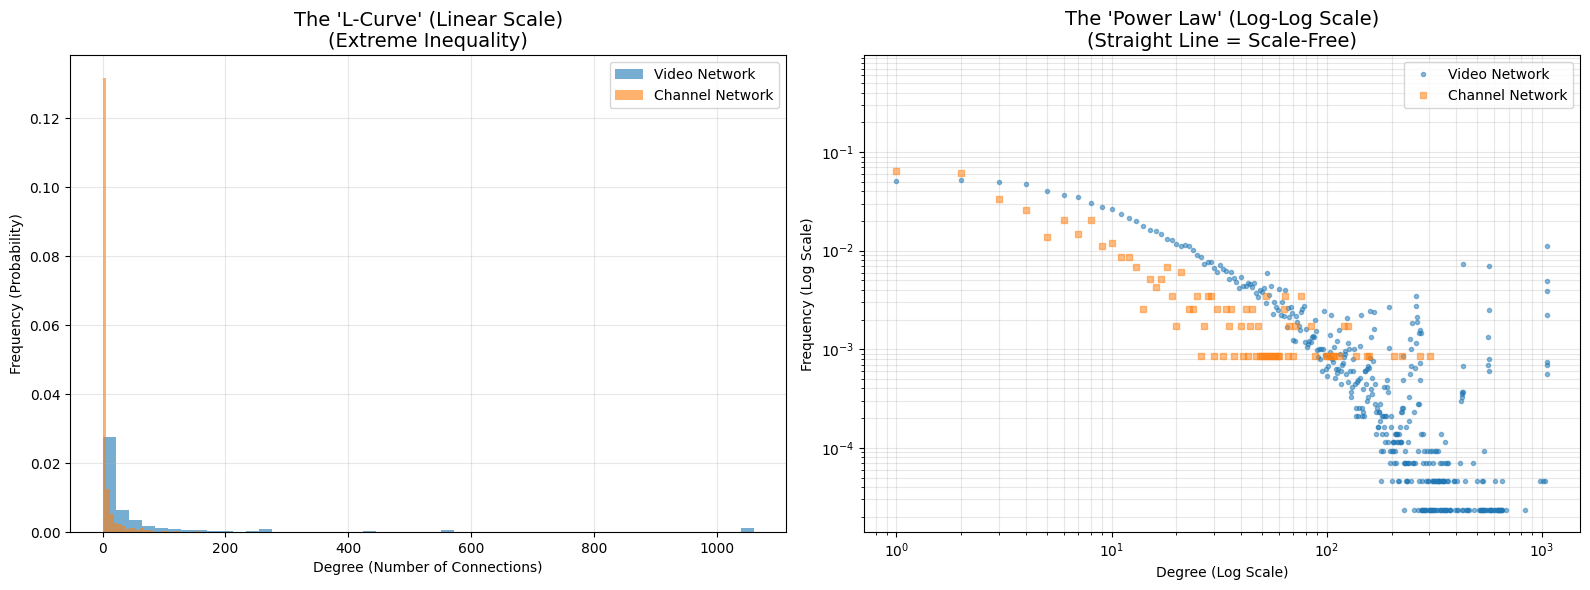


 NETWORK INEQUALITY STATS:
   Max Degree (Video):   1,060 connections (The Viral Hit)
   Max Degree (Channel): 302 connections (The Super-Influencer)
   Avg Degree (Video):   73.3
   Avg Degree (Channel): 7.5


In [20]:
def plot_l_curve_comparison(G_video, G_channel):
    print("Generating L-Curve (Degree Distribution) Comparison...")

    # 1. Get Degrees (Connectivity)
    # -----------------------------
    # List of degrees for every node (e.g., [1, 5, 200, 2, ...])
    degrees_v = [d for n, d in G_video.degree()]
    degrees_c = [d for n, d in G_channel.degree()]

    # 2. Setup the Plot (2 Panels)
    # -----------------------------
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # --- PANEL 1: The "L-Curve" (Linear Scale) ---
    # This shows the "Long Tail" explicitly

    # Histogram for Video Network
    axes[0].hist(degrees_v, bins=50, color='#1f77b4', alpha=0.6, label='Video Network', density=True)
    # Histogram for Channel Network
    axes[0].hist(degrees_c, bins=50, color='#ff7f0e', alpha=0.6, label='Channel Network', density=True)

    axes[0].set_title("The 'L-Curve' (Linear Scale)\n(Extreme Inequality)", fontsize=14)
    axes[0].set_xlabel("Degree (Number of Connections)")
    axes[0].set_ylabel("Frequency (Probability)")
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # --- PANEL 2: The "Power Law" (Log-Log Scale) ---
    # This checks if it follows the "Rich-get-Richer" rule

    # Helper to calculate PDF (Probability Density Function)
    def get_pdf(data):
        values, counts = np.unique(data, return_counts=True)
        probs = counts / len(data)
        return values, probs

    x_v, y_v = get_pdf(degrees_v)
    x_c, y_c = get_pdf(degrees_c)

    axes[1].loglog(x_v, y_v, 'o', color='#1f77b4', alpha=0.5, markersize=3, label='Video Network')
    axes[1].loglog(x_c, y_c, 's', color='#ff7f0e', alpha=0.5, markersize=4, label='Channel Network')

    axes[1].set_title("The 'Power Law' (Log-Log Scale)\n(Straight Line = Scale-Free)", fontsize=14)
    axes[1].set_xlabel("Degree (Log Scale)")
    axes[1].set_ylabel("Frequency (Log Scale)")
    axes[1].legend()
    axes[1].grid(alpha=0.3, which="both")

    plt.tight_layout()
    plt.show()

    # --- STATS ---
    print("\n NETWORK INEQUALITY STATS:")
    print(f"   Max Degree (Video):   {max(degrees_v):,} connections (The Viral Hit)")
    print(f"   Max Degree (Channel): {max(degrees_c):,} connections (The Super-Influencer)")
    print(f"   Avg Degree (Video):   {np.mean(degrees_v):.1f}")
    print(f"   Avg Degree (Channel): {np.mean(degrees_c):.1f}")

# --- EXECUTE ---
if 'G' in locals() and 'G_channels' in locals():
    plot_l_curve_comparison(G, G_channels)
else:
    print("Please run the graph building steps first.")